In [26]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import json
import argparse
import copy

import h5py

import torch
from Transformer.model import my_model, MyDataset

from matplotlib.colors import LogNorm

from scipy.ndimage import gaussian_filter

from power import compute_power, compute_cylindrical_power

from astropy.cosmology import Planck18 as cosmo
from astropy import units as u

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def arcsec_to_cMpc(l_arcsec, z, with_hlittle=True):
    l_rad = l_arcsec * u.arcsec / u.radian
    l_cMpc = ( cosmo.comoving_transverse_distance(z) * l_rad ).to(u.Mpc)
    if with_hlittle:
         return l_cMpc.value * cosmo.h
    else:
        return l_cMpc.value 

def freq_to_comdis(nu_obs, nu_rest, with_hlittle=True):
    z = nu_rest / nu_obs - 1
    if z < 0:
        print("Error: z < 0")
        sys.exit(1)

    d =  cosmo.comoving_distance(z).to(u.Mpc)
    if with_hlittle:
        return d.value * cosmo.h
    else:
        return d.value
    
NLINE = 13
line_names = ["CO(1-0)", "CO(2-1)", "CO(3-2)", "CO(4-3)", "CO(5-4)", "CO(6-5)", "CO(7-6)", "CO(8-7)", "CO(9-8)", "CO(10-9)", "CO(11-10)", "CO(12-11)", "CO(13-12)"]
freq_rest_dict = {
    "CO(1-0)": 115.271,
    "CO(2-1)": 230.538,
    "CO(3-2)": 345.796,
    "CO(4-3)": 461.041,
    "CO(5-4)": 576.268,
    "CO(6-5)": 691.473,
    "CO(7-6)": 806.652,
    "CO(8-7)": 921.800,
    "CO(9-8)": 1036.912,
    "CO(10-9)": 1151.985,
    "CO(11-10)": 1267.014,
    "CO(12-11)": 1381.995,
    "CO(13-12)": 1496.922,
}

model_name = "transformer2"
snapshot_number = 38

fname_list = [ f"group.{snapshot_number}.h5", f"subgroup.{snapshot_number}.h5", f"group_{model_name}.h5"]
titles = ["True (Group)", "True (Subgroup)", "Generated"]
labels = ["group", "subgroup", "generated"]

fname_rsd_list = [ f"group.{snapshot_number}.rsd.h5", f"subgroup.{snapshot_number}.rsd.h5", f"group_{model_name}.rsd.h5"]
titles_rsd= ["True with RSD (Group)", "True with RSD (Subgroup)", "Generated with RSD"]
labels_rsd = ["group_rsd", "subgroup_rsd", "generated"]


group 1223928.4046177275
subgroup 1215685.0561677841
generated 1269647.1575518062


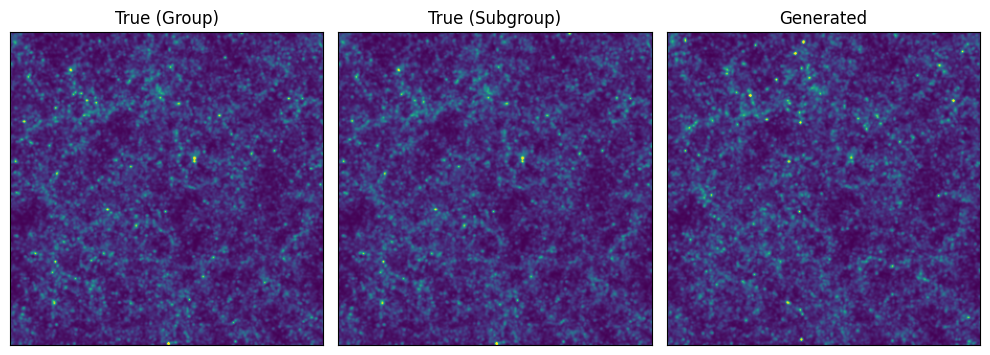

In [27]:
plt.figure(figsize=(10, 4))
for i, fname in enumerate(fname_list):
    with h5py.File(f"output_test/{fname}", "r") as f:
        intensity = f["intensity"][:]
        header = {key: f.attrs[key] for key in f.attrs}

    #image = np.log10(intensity.sum(axis=2))
    image = intensity.sum(axis=2)
    image = gaussian_filter(image, sigma=1)

    vmax = 100

    plt.subplot(1, 3, i+1)
    plt.title(titles[i])
    plt.imshow(image, vmax=vmax)

    plt.xticks([])
    plt.yticks([])
    #plt.colorbar()

    print(labels[i], np.sum(intensity))
    
plt.tight_layout()
plt.savefig(f"figures/images.png")

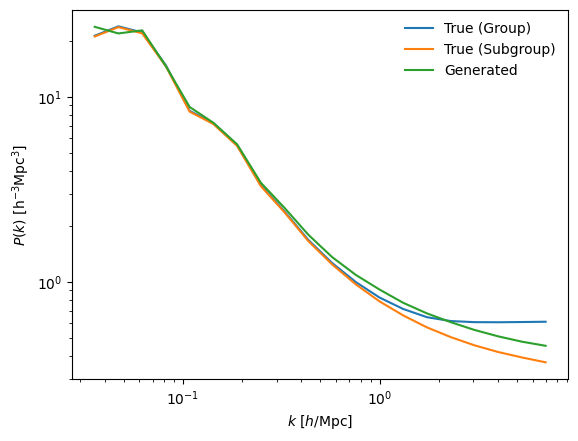

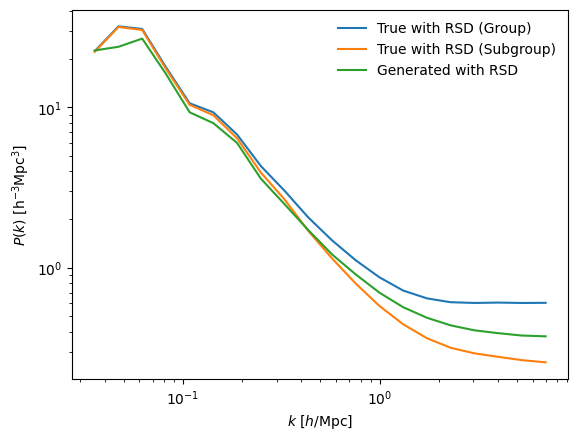

In [28]:
### Power spectrum  
def plot_power(fname_list, titles):
    plt.figure()

    for i, fname in enumerate(fname_list):
        with h5py.File(f"output_test/{fname}", "r") as f:
            intensity = f["intensity"][:]
            header = {key: f.attrs[key] for key in f.attrs}
            boxsize = header["boxsize"] 

        power, k, var = compute_power(intensity, boxlength=boxsize, log_bins=True)
        
        k_values = 0.5 * (k[1:] + k[:-1])
        plt.plot(k_values, power, label=titles[i])
        #plt.errorbar(k_values, power, yerr=np.sqrt(var), fmt="o")

    plt.xlabel(r"$k \ [h/ \rm Mpc]$")
    plt.ylabel(r"$P(k)\ {\rm [h^{-3}  Mpc^3] }$")
    plt.yscale("log")
    plt.xscale("log")
    plt.legend(frameon=False)

plot_power(fname_list, titles)
plot_power(fname_rsd_list, titles_rsd)

[0.03064968 0.04789717 0.07485033 0.11697083 0.18279379 0.28565727
 0.44640509 0.69761047 1.09017657 1.70365126 2.66234636 4.16052762
 6.50177991] [0.03064968 0.04789717 0.07485033 0.11697083 0.18279379 0.28565727
 0.44640509 0.69761047 1.09017657 1.70365126 2.66234636 4.16052762
 6.50177991]
[0.03064968 0.04789717 0.07485033 0.11697083 0.18279379 0.28565727
 0.44640509 0.69761047 1.09017657 1.70365126 2.66234636 4.16052762
 6.50177991] [0.03064968 0.04789717 0.07485033 0.11697083 0.18279379 0.28565727
 0.44640509 0.69761047 1.09017657 1.70365126 2.66234636 4.16052762
 6.50177991]
[0.03064968 0.04789717 0.07485033 0.11697083 0.18279379 0.28565727
 0.44640509 0.69761047 1.09017657 1.70365126 2.66234636 4.16052762
 6.50177991] [0.03064968 0.04789717 0.07485033 0.11697083 0.18279379 0.28565727
 0.44640509 0.69761047 1.09017657 1.70365126 2.66234636 4.16052762
 6.50177991]
[0.03064968 0.04789717 0.07485033 0.11697083 0.18279379 0.28565727
 0.44640509 0.69761047 1.09017657 1.70365126 2.6623

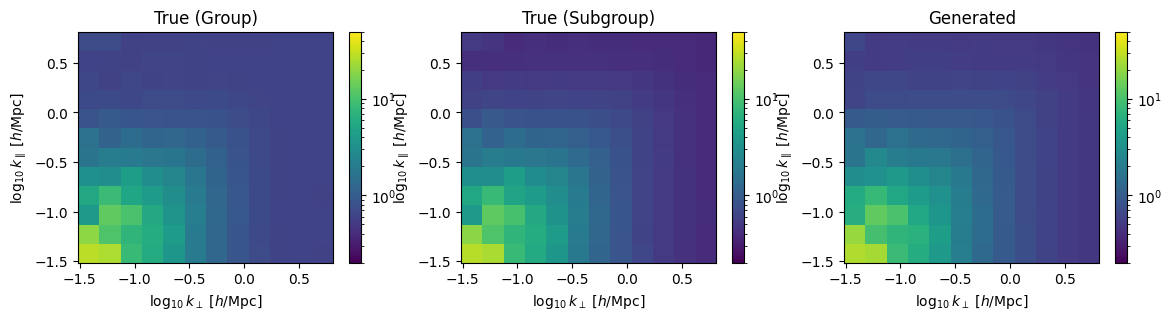

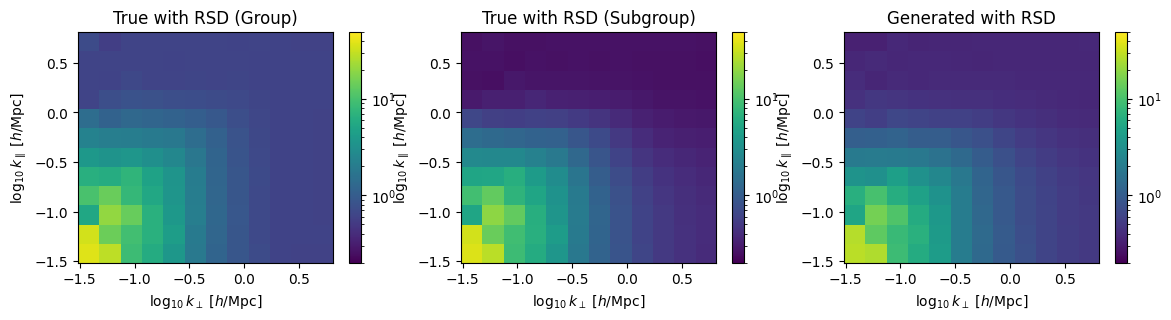

In [29]:
### Cylindrical power spectrum  
def plot_cylindrical_power(fname_list, titles):
    plt.figure(figsize=(14, 3))
    plt.subplots_adjust(wspace=0.2)

    for i, fname in enumerate(fname_list):
        with h5py.File(f"output_test/{fname}", "r") as f:
            intensity = f["intensity"][:]
            header = {key: f.attrs[key] for key in f.attrs}
            boxsize = header["boxsize"] 

        power2d, k_perp, k_para, var = compute_cylindrical_power(intensity, boxlength=boxsize, nbins=12, log_bins=True, use_same_bins=True)
        
        log_k_perp = np.log10(k_perp)
        log_k_para = np.log10(k_para)

        ax = plt.subplot(1, len(fname_list), i+1)
        plt.title(titles[i])

        vmin, vmax = None, None
        vmin, vmax = 0.2, 50
        plt.imshow(power2d, origin="lower", aspect="auto", extent=[log_k_perp.min(), log_k_perp.max(), log_k_para.min(), log_k_para.max()], norm=LogNorm(vmin=vmin, vmax=vmax))
        plt.colorbar()
        plt.xlabel(r"$\log_{10} k_\perp \ [h/ \rm Mpc]$")
        plt.ylabel(r"$\log_{10} k_\parallel \ [h/ \rm Mpc]$")

        #plt.xlim(-1.51, 0)
        #plt.ylim(-1.51, 0)

        print(k_perp, k_para)

plot_cylindrical_power(fname_list, titles)
plot_cylindrical_power(fname_rsd_list, titles_rsd)

/tmp/ipykernel_301303/402710848.py:9: RuntimeWarning: divide by zero encountered in log10
  value = np.log10(intensity).flatten()


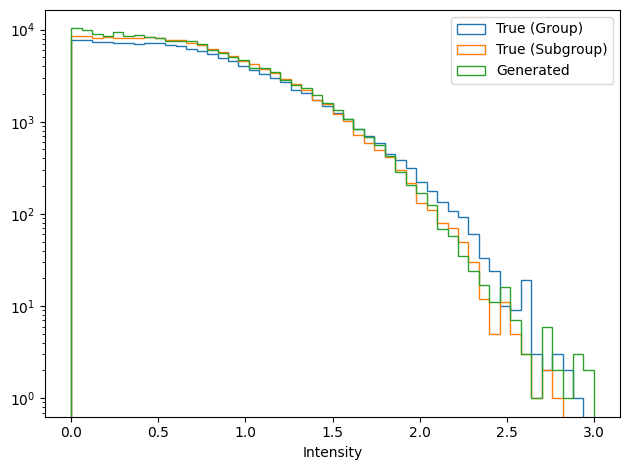

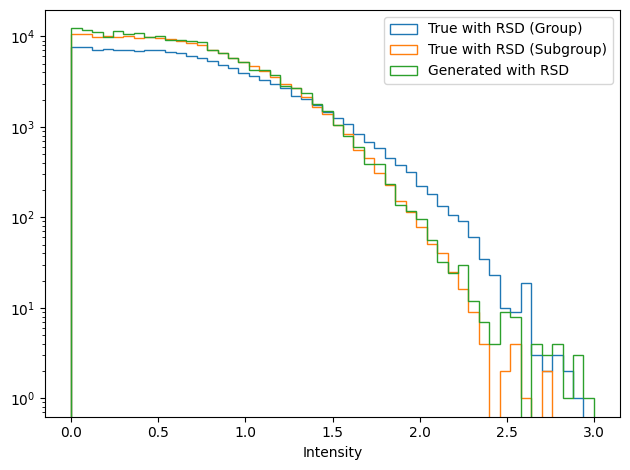

In [19]:
def plot_vid(fname_list, titles):
    plt.figure()

    for i, fname in enumerate(fname_list):
        with h5py.File(f"output_test/{fname}", "r") as f:
            intensity = f["intensity"][:]
            header = {key: f.attrs[key] for key in f.attrs}

        value = np.log10(intensity).flatten()
        plt.hist(value, range=(0, 3), bins=50, histtype="step", label=titles[i])

    plt.xlabel("Intensity")
    plt.yscale("log")
    plt.legend()
    plt.tight_layout()

plot_vid(fname_list, titles)
plot_vid(fname_rsd_list, titles_rsd)

In [3]:

from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
H = cosmo.H(2) / u.km * u.Mpc * u.s
print(H)
print(H*2)

cosmo.H(2).to(u.km/u.s/u.Mpc).value
print(cosmo.H(0).to(u.km/u.s/u.Mpc).value)

203.64879387763798
407.29758775527597
67.74


In [21]:
from Transformer.model import my_model
from Transformer.NN.model import my_NN_model

data = np.loadtxt("./Transformer/TNG_data/group.38.txt")
# Input data: logm, x, y, z, vx, vy, vz, value

logm = data[:, 0]
mask = logm > 11
data = data[mask]

norm_params = np.loadtxt("./Transformer/norm_params.txt")
xmin = norm_params[:,0]
xmax = norm_params[:,1]

### load Transformer
model_dir = "./Transformer/output/transformer2"
NN_model_dir = "./Transformer/NN/output"
with open(f"{model_dir}/args.json", "r") as f:
    opt = json.load(f, object_hook=lambda d: argparse.Namespace(**d))

model = my_model(opt)
model.to(device)

model.load_state_dict(torch.load(f"{model_dir}/model.pth"))
model.eval()

### load NN
with open(f"{NN_model_dir}/args.json", "r") as f:
    opt_NN = json.load(f, object_hook=lambda d: argparse.Namespace(**d))

model_NN = my_NN_model(opt_NN)
model_NN.to(device)

model_NN.load_state_dict(torch.load(f"{NN_model_dir}/model.pth"))
model_NN.eval()

### normalize data
logm = (logm - xmin[0]) / (xmax[0] - xmin[0])
logm = torch.from_numpy(logm).float().to(device)

num_batch = (len(logm) + opt.batch_size - 1) // opt.batch_size
#for batch_idx in range(num_batch):
x = []
y = []
y_true = []
for batch_idx in range(num_batch):
    start = batch_idx * opt.batch_size 
    logm_batch = logm[start: start+opt.batch_size, None] # (batch_size, 1)
    generated, _ = model.generate(logm_batch) # (batch_size, seq_length, 1)

    generated = generated[:, 1, :] # (batch_size, 1)

    x_NN = torch.cat([logm_batch, generated], dim=1) 
    g_NN, _ = model_NN.generate(x_NN) # (batch_size, 1)
    
    x_NN = x_NN.cpu().detach().numpy()
    g_NN = g_NN.cpu().detach().numpy()
        
    x.append(x_NN)
    y.append(g_NN)

    if batch_idx > 200:
        break

x = np.concatenate(x, axis=0)
y = np.concatenate(y, axis=0)


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


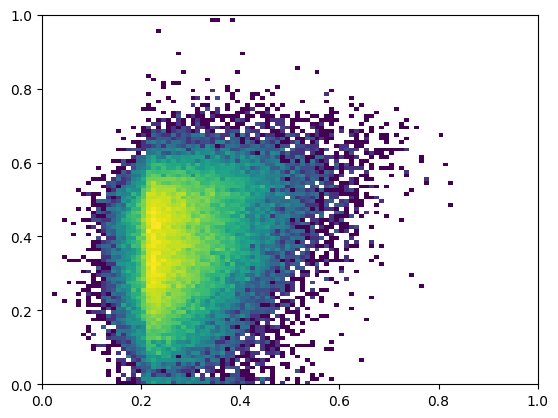

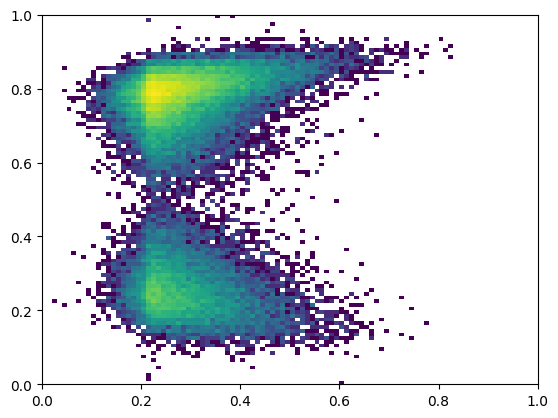

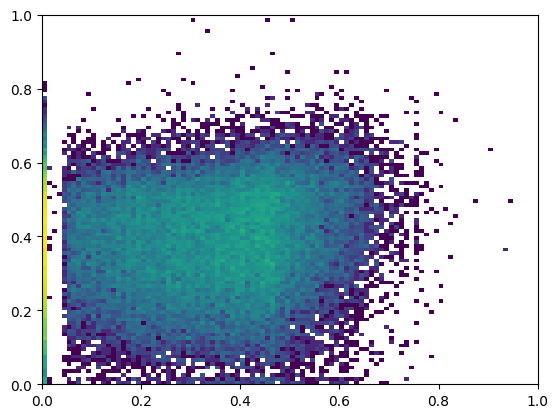

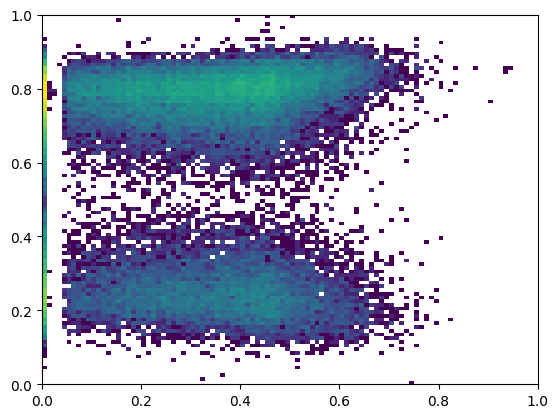

In [ ]:
plt.figure()
hist2d = plt.hist2d(x[:, 0], y[:, 0], bins=100, range=[[0, 1], [0, 1]], norm=LogNorm())

plt.figure()
hist2d = plt.hist2d(x[:, 0], y[:, 1], bins=100, range=[[0, 1], [0, 1]], norm=LogNorm())

plt.figure()
hist2d = plt.hist2d(x[:, 1], y[:, 0], bins=100, range=[[0, 1], [0, 1]], norm=LogNorm())

plt.figure()
hist2d = plt.hist2d(x[:, 1], y[:, 1], bins=100, range=[[0, 1], [0, 1]], norm=LogNorm())